In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from numpy.fft import *
import pyarrow.parquet as pq
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

### 1 - Loading Data
Signals
* 800.000 measurement points for 8712 signals.
* The signals are three-phased so there are 2904 distinct signaling instances.

In [2]:
%%time
#only take 999 signals
signals = pq.read_table('input/train.parquet', columns=[str(i) for i in range(999)]).to_pandas()

CPU times: user 12.7 s, sys: 3.44 s, total: 16.1 s
Wall time: 1.15 s


In [3]:
signals.shape

(800000, 999)

In [4]:
signals.loc[:5,'0':'10']

,0,1,2,3,4,5,6,7,8,9,10
0,18,1,-19,-16,-5,19,-15,15,-1,-16,-9
1,18,0,-19,-17,-6,19,-17,16,0,-15,-10
2,17,-1,-20,-17,-6,19,-17,15,-3,-15,-10
3,18,1,-19,-16,-5,20,-16,16,0,-15,-9
4,18,0,-19,-16,-5,20,-17,16,-2,-14,-8
5,18,0,-20,-15,-4,20,-16,15,-2,-12,-7


In [5]:
signals.T.head()

,0,1,2,3,4,5,6,7,8,9,...,799990,799991,799992,799993,799994,799995,799996,799997,799998,799999
0,18,18,17,18,18,18,19,18,18,17,...,18,18,17,17,18,19,19,17,19,17
1,1,0,-1,1,0,0,1,0,0,0,...,1,0,0,0,0,2,1,0,1,0
2,-19,-19,-20,-19,-19,-20,-18,-19,-20,-19,...,-19,-20,-21,-18,-19,-18,-19,-19,-18,-19
3,-16,-17,-17,-16,-16,-15,-16,-17,-18,-17,...,-15,-15,-15,-15,-15,-15,-15,-15,-14,-14
4,-5,-6,-6,-5,-5,-4,-5,-7,-7,-7,...,-4,-4,-4,-5,-4,-4,-4,-4,-3,-4


In [6]:
signals = np.array(signals).T.reshape((999//3, 3, 800000))

In [7]:
signals.shape

(333, 3, 800000)

In [8]:
signals[:5]

array([[[ 18,  18,  17, ...,  17,  19,  17],
        [  1,   0,  -1, ...,   0,   1,   0],
        [-19, -19, -20, ..., -19, -18, -19]],

       [[-16, -17, -17, ..., -15, -14, -14],
        [ -5,  -6,  -6, ...,  -4,  -3,  -4],
        [ 19,  19,  19, ...,  21,  22,  21]],

       [[-15, -17, -17, ..., -16, -16, -17],
        [ 15,  16,  15, ...,  14,  17,  14],
        [ -1,   0,  -3, ...,  -2,  -1,  -4]],

       [[-16, -15, -15, ..., -18, -17, -15],
        [ -9, -10, -10, ..., -12, -11, -10],
        [ 23,  22,  22, ...,  19,  20,  22]],

       [[ -1,   0,  -1, ...,  -1,  -2,  -2],
        [-17, -16, -16, ..., -17, -17, -18],
        [ 16,  17,  17, ...,  17,  16,  16]]], dtype=int8)

In [9]:
signals[0, 0, :]

array([18, 18, 17, ..., 17, 19, 17], dtype=int8)

In [10]:
signals[0, 1, :]

array([ 1,  0, -1, ...,  0,  1,  0], dtype=int8)

In [11]:
signals[0, 2, :]

array([-19, -19, -20, ..., -19, -18, -19], dtype=int8)

##### plot the graph _target 0

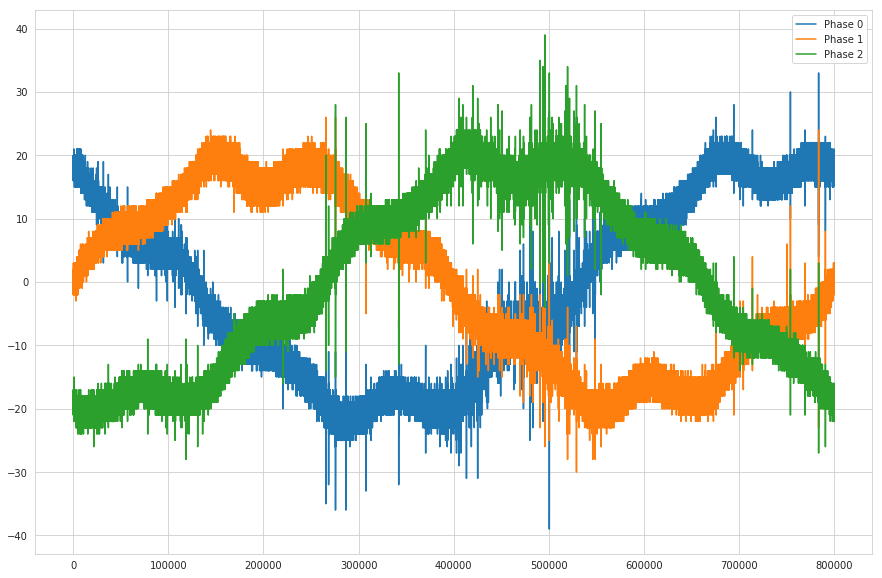

In [12]:
plt.figure(figsize=(15, 10))
plt.plot(signals[0, 0, :], label='Phase 0')
plt.plot(signals[0, 1, :], label='Phase 1')
plt.plot(signals[0, 2, :], label='Phase 2')
plt.legend()
plt.show()

##### plot the graph _target 1

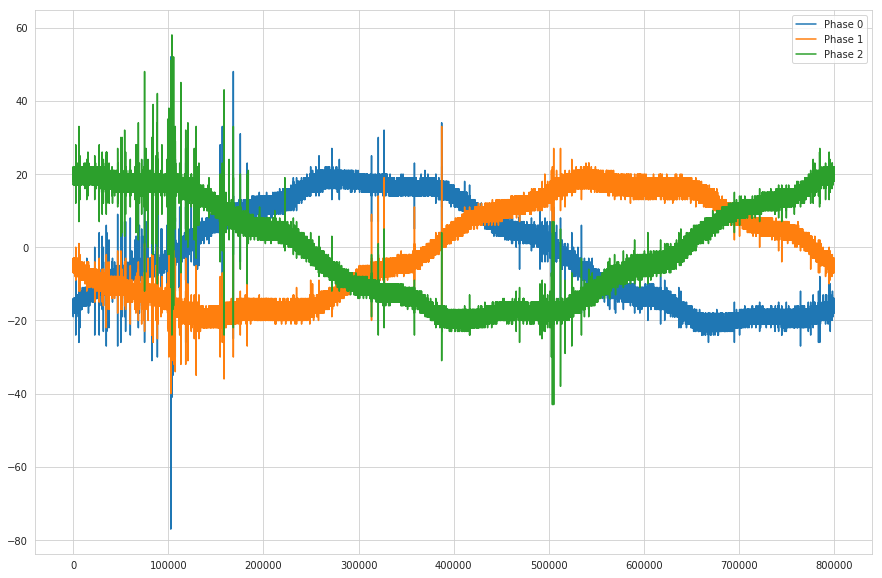

In [13]:
plt.figure(figsize=(15, 10))
plt.plot(signals[1, 0, :], label='Phase 0')
plt.plot(signals[1, 1, :], label='Phase 1')
plt.plot(signals[1, 2, :], label='Phase 2')
plt.legend()
plt.show()

#### Target

In [14]:
train_df = pd.read_csv('input/metadata_train.csv')
train_df[:10]

,signal_id,id_measurement,phase,target
0,0,0,0,0
1,1,0,1,0
2,2,0,2,0
3,3,1,0,1
4,4,1,1,1
5,5,1,2,1
6,6,2,0,0
7,7,2,1,0
8,8,2,2,0
9,9,3,0,0


In [15]:
#every three phase one cycle
target = train_df['target'][::3]

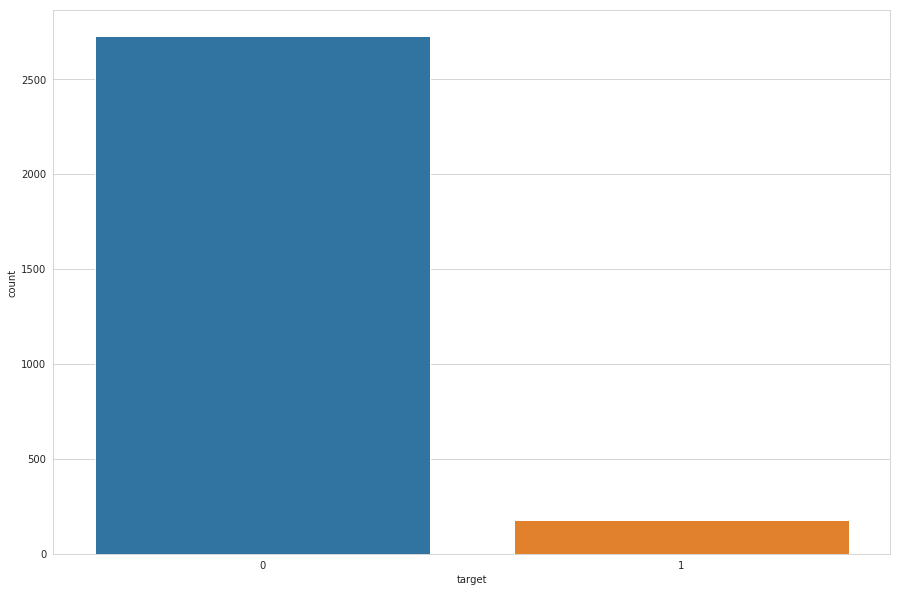

In [16]:
plt.figure(figsize=(15, 10))
sns.countplot(target)
plt.show()

### 2 - Smoothing by mean
The idea is to reduce the length and the noise of the signal by merging  k neighbour values into their average

In [17]:
signals.shape[2]

800000

In [22]:
signals.shape

(333, 3, 800000)

In [46]:
np.mean(signals[:,:,0:100],axis=2)

array([[ 1.772e+01,  1.000e-01, -1.927e+01],
       [-1.648e+01, -5.340e+00,  1.946e+01],
       [-1.586e+01,  1.612e+01, -1.020e+00],
       [-1.523e+01, -9.390e+00,  2.297e+01],
       [-7.700e-01, -1.679e+01,  1.663e+01],
       [-7.920e+00,  1.730e+01, -1.025e+01],
       [ 1.875e+01, -9.790e+00, -1.364e+01],
       [-7.700e+00,  2.242e+01, -1.506e+01],
       [-2.092e+01,  1.348e+01,  4.330e+00],
       [-1.921e+01,  1.730e+00,  1.547e+01],
       [ 1.488e+01, -1.490e+00, -1.667e+01],
       [ 3.900e+00,  1.522e+01, -2.106e+01],
       [ 8.660e+00, -1.579e+01,  7.070e+00],
       [ 9.850e+00, -1.754e+01,  5.490e+00],
       [-1.752e+01,  1.677e+01, -1.230e+00],
       [-8.360e+00,  1.590e+01, -1.362e+01],
       [-4.670e+00,  1.918e+01, -1.590e+01],
       [ 1.455e+01,  2.660e+00, -2.071e+01],
       [-1.826e+01, -3.270e+00,  2.070e+01],
       [-1.948e+01,  1.424e+01,  2.160e+00],
       [-3.660e+00, -1.777e+01,  1.889e+01],
       [-3.840e+00,  2.244e+01, -1.835e+01],
       [-1

In [18]:
#sampled.shape = (333, 3, 8000)
#mean the third area 
def sample(signal, kernel_size):
    sampled = np.zeros((signal.shape[0], signal.shape[1], signal.shape[2]//kernel_size))
    for i in range(signal.shape[2]//kernel_size):
        begin = kernel_size * i
        end = min(kernel_size * (i + 1), signal.shape[2])
        sampled[:, :, i] = np.mean(signal[:, :, begin:end], axis=2)
    return sampled

In [19]:
sampled = sample(signals, 100)

In [21]:
sampled.shape

(333, 3, 8000)

In [34]:
sampled

array([[[ 17.72,  17.81,  17.9 , ...,  17.92,  17.97,  17.92],
        [  0.1 ,   0.12,   0.52, ...,   0.48,   0.53,   0.49],
        [-19.27, -19.24, -18.78, ..., -18.93, -19.03, -18.97]],

       [[-16.48, -16.24, -16.17, ..., -15.7 , -15.48, -15.48],
        [ -5.34,  -5.03,  -5.15, ...,  -4.97,  -4.63,  -4.81],
        [ 19.46,  19.88,  19.51, ...,  19.96,  20.26,  20.19]],

       [[-15.86, -16.65, -15.77, ..., -15.35, -14.59, -16.15],
        [ 16.12,  15.35,  15.89, ...,  16.15,  16.96,  15.42],
        [ -1.02,  -1.48,  -0.99, ...,  -1.27,  -0.88,  -1.83]],

       ...,

       [[-19.08, -18.28, -18.84, ..., -18.99, -18.93, -19.02],
        [  8.03,   9.36,   8.19, ...,   8.51,   8.14,   8.04],
        [  8.07,   9.14,   7.76, ...,   8.39,   8.25,   8.17]],

       [[ 18.07,  17.73,  18.34, ...,  16.09,  16.13,  15.41],
        [-21.06, -21.34, -20.07, ..., -18.97, -19.1 , -20.13],
        [  0.28,   0.04,   0.99, ...,   1.49,   1.49,   0.51]],

       [[ 19.02,  18.84,  18.35,

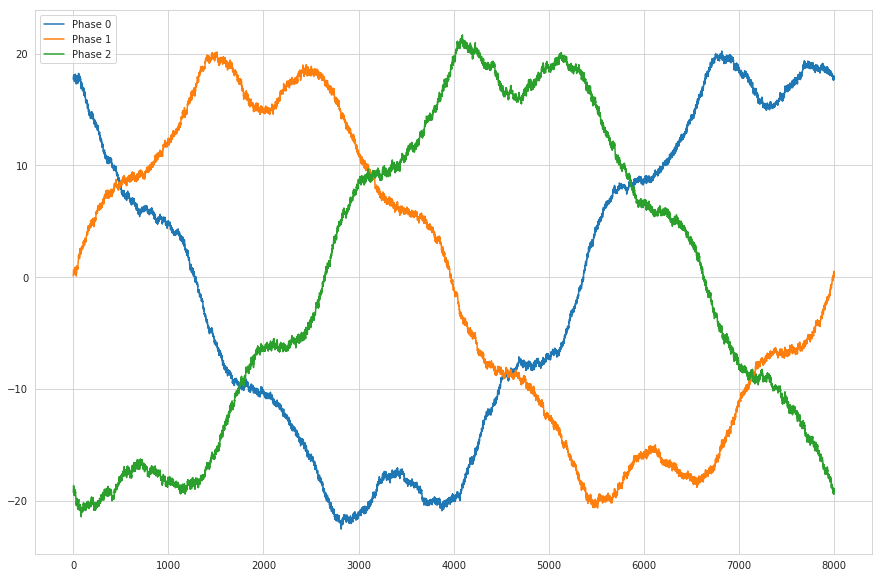

In [20]:
plt.figure(figsize=(15, 10))
plt.plot(sampled[0, 0, :], label='Phase 0')
plt.plot(sampled[0, 1, :], label='Phase 1')
plt.plot(sampled[0, 2, :], label='Phase 2')
plt.legend()
plt.show()

In [38]:
X = np.array([[[1,2,3,4]],[[1,2,3,4]]])

In [39]:
X.shape

(2, 1, 4)

In [40]:
np.mean(X,axis=2)

array([[2.5],
       [2.5]])

In [41]:
X

array([[[1, 2, 3, 4]],

       [[1, 2, 3, 4]]])